# Crop price recommender system

In [1]:
# IMPORTING FILES
import pandas as pd
import numpy as np
from pathlib import PurePosixPath, PureWindowsPath
from matplotlib import pyplot as plt
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# IN-HOUSE FUNCTION: RETURN DIRECTORY SPECIFIC TO RUNNING OS
def get_directory(path):
    if os.name == 'posix':
        return str(PurePosixPath(path))
    else:
        return str(PureWindowsPath(path))

In [3]:
# VARIABLES
HARGAPANGAN_LOCATION = get_directory('./dataset/time-series')
TRAIN_SPLIT = 0.8
WINDOW_SIZE = 180
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

# TEST
print(HARGAPANGAN_LOCATION)

dataset\time-series


For the following code block, we are getting all the data from four excel files (trust me, the data is spread horizontally and I don't wanna mess too much)

In [4]:
_APPLE = pd.read_excel(get_directory(HARGAPANGAN_LOCATION + '/Harga Pangan - Compiled.xlsx'), skiprows=1, sheet_name='apel').set_index('Tanggal')
_ORANGE = pd.read_excel(get_directory(HARGAPANGAN_LOCATION + '/Harga Pangan - Compiled.xlsx'), skiprows=1, sheet_name='jeruk').set_index('Tanggal')

In [5]:
# Before setting as timedate
_APPLE.head()

,Harga Impor,Harga Lokal
Tanggal,,
15/12/2017,35000,25000
18/12/2017,40000,23350
19/12/2017,35850,24150
20/12/2017,40000,23850
21/12/2017,40000,22750


In [6]:
_APPLE.index = pd.DatetimeIndex(pd.to_datetime(_APPLE.index, format='%d/%m/%Y'))
_ORANGE.index = pd.DatetimeIndex(pd.to_datetime(_ORANGE.index, format='%d/%m/%Y'))

In [7]:
# Date shenanigans
_APPLE = _APPLE.reindex(pd.date_range(_APPLE.index.min(), _APPLE.index.max(), freq='D'))
_ORANGE = _ORANGE.reindex(pd.date_range(_ORANGE.index.min(), _ORANGE.index.max(), freq='D'))

In [8]:
_APPLE.head()

,Harga Impor,Harga Lokal
2017-12-15,35000,25000
2017-12-16,NaN,NaN
2017-12-17,NaN,NaN
2017-12-18,40000,23350
2017-12-19,35850,24150


In [9]:
# Clean data from strips
_APPLE.loc[:, 'Harga Lokal'] = _APPLE['Harga Lokal'].replace('-', np.NaN)
_APPLE.loc[:, 'Harga Impor'] = _APPLE['Harga Lokal'].replace('-', np.NaN)
_ORANGE.loc[:, 'Harga Lokal'] = _ORANGE['Harga Lokal'].replace('-', np.NaN)
_ORANGE.loc[:, 'Harga Impor'] = _ORANGE['Harga Lokal'].replace('-', np.NaN)

In [10]:
_APPLE

,Harga Impor,Harga Lokal
2017-12-15,25000.0,25000.0
2017-12-16,NaN,NaN
2017-12-17,NaN,NaN
2017-12-18,23350.0,23350.0
2017-12-19,24150.0,24150.0
...,...,...
2021-05-24,28150.0,28150.0
2021-05-25,28150.0,28150.0
2021-05-26,30000.0,30000.0
2021-05-27,26650.0,26650.0


In [11]:
# Filling up NaN values for Apple
for i in range(len(_APPLE['Harga Lokal'].index)):
    if _APPLE.loc[_APPLE.index[i], 'Harga Lokal'] != _APPLE.loc[_APPLE.index[i], 'Harga Lokal']:   # check for NaN
        _temp = np.array([])
        for j in range(-2, 3):
            if _APPLE.loc[_APPLE.index[i+j], 'Harga Lokal'] == _APPLE.loc[_APPLE.index[i+j], 'Harga Lokal']:
                _temp = np.append(_temp, _APPLE.loc[_APPLE.index[i+j], 'Harga Lokal'])
        _APPLE.loc[_APPLE.index[i], 'Harga Lokal'] = sum(_temp) / len(_temp)

# Filling up NaN values for Orange
for i in range(len(_ORANGE['Harga Lokal'].index)):
    if _ORANGE.loc[_ORANGE.index[i], 'Harga Lokal'] != _ORANGE.loc[_ORANGE.index[i], 'Harga Lokal']:   # check for NaN
        _temp = np.array([])
        for j in range(-2, 3):
            if _ORANGE.loc[_ORANGE.index[i+j], 'Harga Lokal'] == _ORANGE.loc[_ORANGE.index[i+j], 'Harga Lokal']:
                _temp = np.append(_temp, _ORANGE.loc[_ORANGE.index[i+j], 'Harga Lokal'])
        _ORANGE.loc[_ORANGE.index[i], 'Harga Lokal'] = sum(_temp) / len(_temp)

In [12]:
_APPLE.loc['28/05/2021', 'Harga Lokal']

27500.0

In [13]:
len(np.shape(np.array(_APPLE['Harga Lokal'])))

1

In [14]:
_APPLE

,Harga Impor,Harga Lokal
2017-12-15,25000.0,25000.000000
2017-12-16,NaN,25283.333333
2017-12-17,NaN,24445.833333
2017-12-18,23350.0,23350.000000
2017-12-19,24150.0,24150.000000
...,...,...
2021-05-24,28150.0,28150.000000
2021-05-25,28150.0,28150.000000
2021-05-26,30000.0,30000.000000
2021-05-27,26650.0,26650.000000


In [15]:
_ORANGE

,Harga Impor,Harga Lokal
2017-12-15,10000.0,10000.0
2017-12-16,NaN,14250.0
2017-12-17,NaN,14187.5
2017-12-18,15000.0,15000.0
2017-12-19,17500.0,17500.0
...,...,...
2021-05-24,17200.0,17200.0
2021-05-25,16600.0,16600.0
2021-05-26,14500.0,14500.0
2021-05-27,17750.0,17750.0


In [16]:
_APPLE.index

DatetimeIndex(['2017-12-15', '2017-12-16', '2017-12-17', '2017-12-18',
               '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24',
               ...
               '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
               '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28'],
              dtype='datetime64[ns]', length=1261, freq='D')

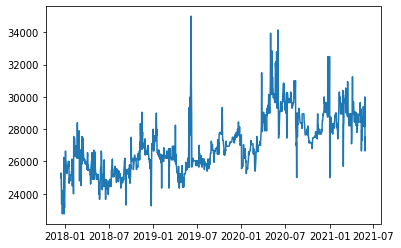

<Figure size 1152x648 with 0 Axes>

In [17]:
# Here is the time series for the average apple price in Indonesia

plt.plot(_APPLE.index, _APPLE['Harga Lokal'])
plt.figure(figsize=(16,9))
plt.show()

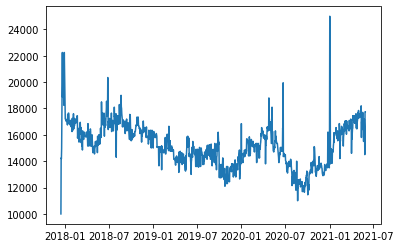

<Figure size 1152x648 with 0 Axes>

In [18]:
# Here is the time series for the average orange price in Indonesia

plt.plot(_ORANGE.index, _ORANGE['Harga Lokal'])
plt.figure(figsize=(16,9))
plt.show()

In [19]:
_APPLE.describe()

,Harga Impor,Harga Lokal
count,880.000000,1261.000000
mean,27091.079545,27072.218734
std,1746.941900,1744.358504
min,22750.000000,22750.000000
25%,25850.000000,25800.000000
50%,26800.000000,26800.000000
75%,28200.000000,28225.000000
max,35000.000000,35000.000000


In [20]:
_ORANGE.describe()

,Harga Impor,Harga Lokal
count,880.000000,1261.000000
mean,15209.545455,15239.862543
std,1615.887355,1599.175193
min,10000.000000,10000.000000
25%,14000.000000,14095.833333
50%,15150.000000,15200.000000
75%,16362.500000,16416.666667
max,25000.000000,25000.000000


## Data preparation - for machine learning model

In [21]:
# Data normalisation
_APPLE.loc[:, 'Harga Lokal'] = _APPLE['Harga Lokal'] / int(_APPLE['Harga Lokal'].max())
_ORANGE.loc[:, 'Harga Lokal'] = _ORANGE['Harga Lokal'] / int(_ORANGE['Harga Lokal'].max())

In [22]:
# Sanity check
_APPLE

,Harga Impor,Harga Lokal
2017-12-15,25000.0,0.714286
2017-12-16,NaN,0.722381
2017-12-17,NaN,0.698452
2017-12-18,23350.0,0.667143
2017-12-19,24150.0,0.690000
...,...,...
2021-05-24,28150.0,0.804286
2021-05-25,28150.0,0.804286
2021-05-26,30000.0,0.857143
2021-05-27,26650.0,0.761429


In [23]:
# Train-test split
_count = len(_APPLE)
_APPLE_LOCAL = _APPLE['Harga Lokal'].values
_APPLE_TRAIN = _APPLE_LOCAL[:int(_count*TRAIN_SPLIT)]
_APPLE_TEST = _APPLE_LOCAL[int(_count*TRAIN_SPLIT):]

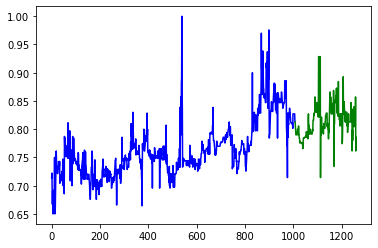

In [24]:
# Visualize the difference between train and test
plt.plot(
    range(int(_count * TRAIN_SPLIT)), _APPLE_TRAIN, 'b',
    range(int(_count * TRAIN_SPLIT), _count), _APPLE_TEST, 'g'
)
plt.show()

In [25]:
# Nyomot dari Mr. Moroney ya yang ini :)
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()
_input = windowed_dataset(_APPLE_TRAIN, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
_input_val = windowed_dataset(_APPLE_TEST, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [27]:
time_series_pred = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = False)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-10 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-10, momentum = 0.9)
time_series_pred.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae', 'acc']
)

history_opt = time_series_pred.fit(
    _input,
    epochs = 250,
    callbacks = [learning_rate_scheduler]
)

=============] - 0s 4ms/step - loss: 0.1856 - mae: 0.6077 - acc: 0.0000e+00
Epoch 77/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1865 - mae: 0.6089 - acc: 0.0000e+00
Epoch 78/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1844 - mae: 0.6057 - acc: 0.0000e+00
Epoch 79/250
28/28 [==============================] - 0s 5ms/step - loss: 0.1852 - mae: 0.6070 - acc: 0.0000e+00
Epoch 80/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1856 - mae: 0.6075 - acc: 0.0000e+00
Epoch 81/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1850 - mae: 0.6067 - acc: 0.0000e+00
Epoch 82/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1863 - mae: 0.6087 - acc: 0.0000e+00
Epoch 83/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1838 - mae: 0.6045 - acc: 0.0000e+00
Epoch 84/250
28/28 [==============================] - 0s 4ms/step - loss: 0.1852 - mae: 0.6070 - acc: 0.0000e+00
Epoch 85/250
28/28 [

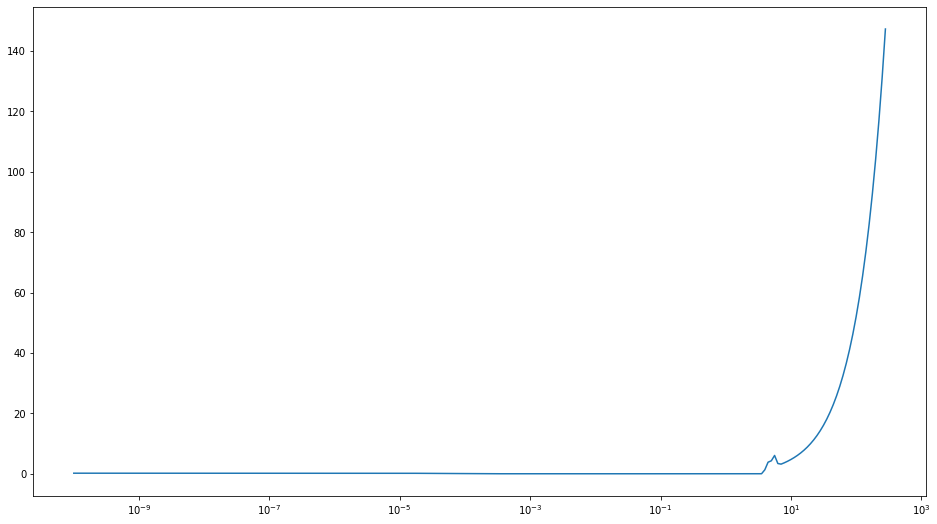

In [28]:
plt.figure(figsize=(16,9))
plt.semilogx(history_opt.history['lr'], history_opt.history['loss'])
plt.show()

Optimizer - second try

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()

time_series_pred = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = False)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9)
time_series_pred.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae', 'acc']
)

history_opt = time_series_pred.fit(
    _input,
    epochs = 80,
    callbacks = [learning_rate_scheduler]
)

Epoch 1/80
28/28 [==============================] - 1s 5ms/step - loss: 0.1308 - mae: 0.5094 - acc: 0.0000e+00
Epoch 2/80
28/28 [==============================] - 0s 4ms/step - loss: 0.1109 - mae: 0.4691 - acc: 0.0000e+00
Epoch 3/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0883 - mae: 0.4182 - acc: 0.0000e+00
Epoch 4/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0698 - mae: 0.3706 - acc: 0.0000e+00
Epoch 5/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0533 - mae: 0.3232 - acc: 0.0000e+00
Epoch 6/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0390 - mae: 0.2759 - acc: 2.9222e-04
Epoch 7/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0277 - mae: 0.2315 - acc: 9.2777e-04
Epoch 8/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0190 - mae: 0.1905 - acc: 2.0283e-04
Epoch 9/80
28/28 [==============================] - 0s 4ms/step - loss: 0.0127 - mae: 0.1531 - acc: 8.4488e-04
E

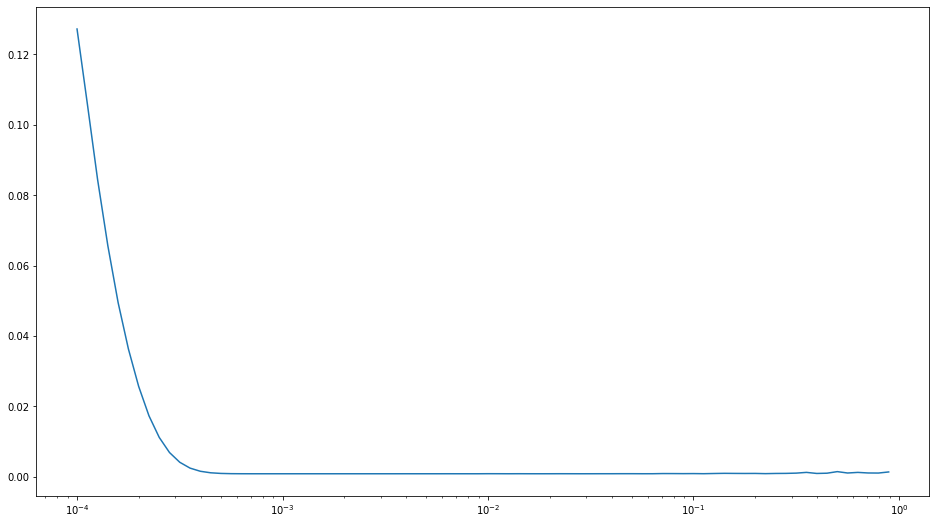

In [30]:
plt.figure(figsize=(16,9))
plt.semilogx(history_opt.history['lr'], history_opt.history['loss'])
plt.show()

Verdict: we get 1e-3 as our learning rate.

In [40]:
# Learning - for real
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()

time_series_pred = tf.keras.models.Sequential([
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    #tf.keras.layers.LSTM(16, return_sequences = True),
    #tf.keras.layers.LSTM(128, return_sequences = False),
    #tf.keras.layers.GRU(64),
    #tf.keras.layers.Dropout(0.5),   # Dropout is attributed to https://arxiv.org/abs/1901.00069
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate = 3e-7, momentum = 0.9)
time_series_pred.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = optimizer,
    #optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['mse']
)

history = time_series_pred.fit(
    _input,
    epochs = 200,
    validation_data = _input_val
)

=================] - 0s 4ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 51/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0512 - mse: 0.0512 - val_loss: 0.0649 - val_mse: 0.0649
Epoch 52/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0610 - val_mse: 0.0610
Epoch 53/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0574 - val_mse: 0.0574
Epoch 54/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0539 - val_mse: 0.0539
Epoch 55/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 56/200
52/52 [==============================] - 0s 3ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 57/200
52/52 [==============================] - 0s 4ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.

In [41]:
# Show model summary. Check that the output is proper (None, 1)
time_series_pred.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               23168     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 39,809
Trainable params: 39,809
Non-trainable params: 0
_________________________________________________________________


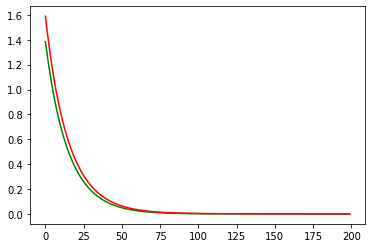

In [42]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], 'g', range(len(history.history['val_loss'])), history.history['val_loss'], 'r')
plt.show()

Predicting 827

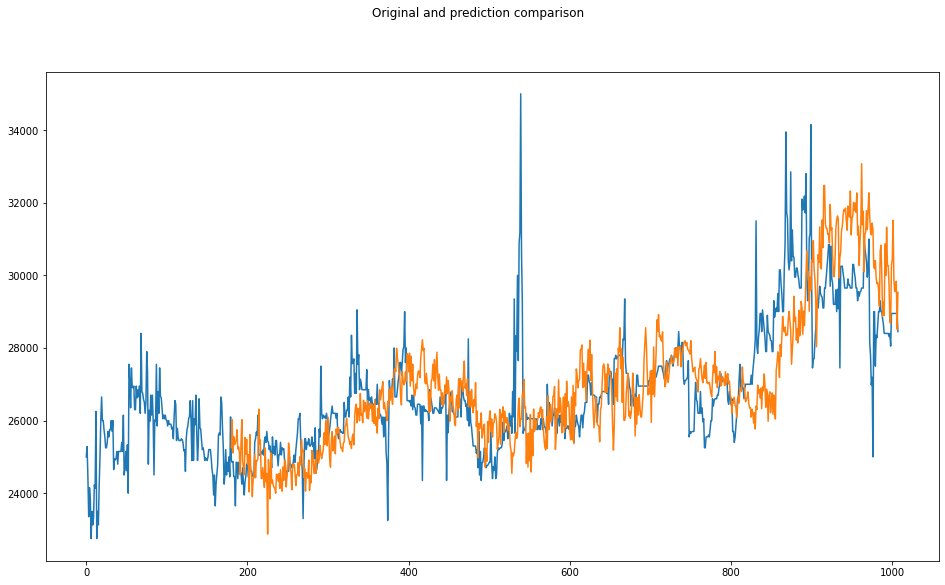

In [43]:
forecast = []
results = []
for i in range(len(_APPLE_TRAIN) - WINDOW_SIZE):
    print('\r'+'Predicting '+str(i), end='')
    forecast.append(time_series_pred.predict(_APPLE_TRAIN[i:i + WINDOW_SIZE][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

fig = plt.figure(figsize=(16,9))
plt.suptitle('Original and prediction comparison')
plt.plot(range(len(_APPLE_TRAIN)), _APPLE_TRAIN * 35000)
plt.plot(range(WINDOW_SIZE, len(results) + WINDOW_SIZE), results * 35000)
plt.show()

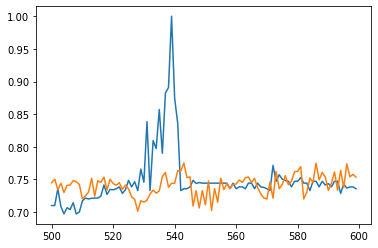

In [44]:
# FOCUS ON SEVERAL SPACE
plt.plot(range(500, 600), _APPLE_LOCAL[500:600])
plt.plot(range(500, 600), results[500-WINDOW_SIZE:600-WINDOW_SIZE])

Predicting 72

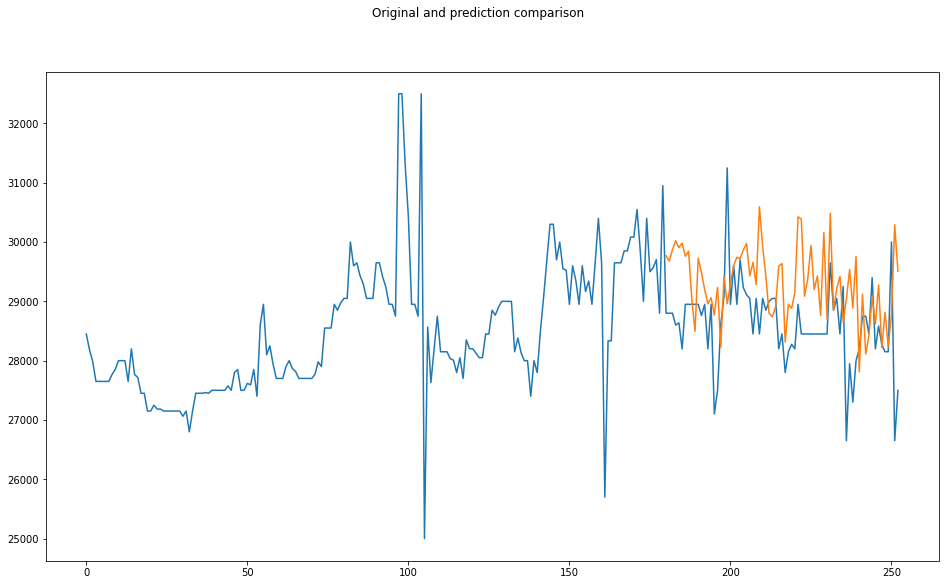

In [45]:
forecast_val = []
results_val = []
for i in range(len(_APPLE_TEST) - WINDOW_SIZE):
    print('\r'+'Predicting '+str(i), end='')
    forecast_val.append(time_series_pred.predict(_APPLE_TEST[i:i + WINDOW_SIZE][np.newaxis]))

results_val = np.array(forecast_val)[:, 0, 0]

fig = plt.figure(figsize=(16,9))
plt.suptitle('Original and prediction comparison')
plt.plot(range(len(_APPLE_TEST)), _APPLE_TEST * 35000)
plt.plot(range(WINDOW_SIZE, len(results_val) + WINDOW_SIZE), results_val * 35000)
plt.show()

In [46]:
# Can it recommend prices for 128 more days? (SPOILER: DOWNSIDE MITIGATED MUCH)
forecast_1y = forecast.copy()
results_1y = results.copy()

for i in range(128):
    print('\r'+'Forecasting '+str(i), end='')
    _temp = time_series_pred.predict(results_1y[
        -1 * WINDOW_SIZE:
        ][np.newaxis])
    results_1y = np.append(results_1y, _temp[0, 0])

#results_1y = results_1y[:, 0, 0]

Forecasting 127

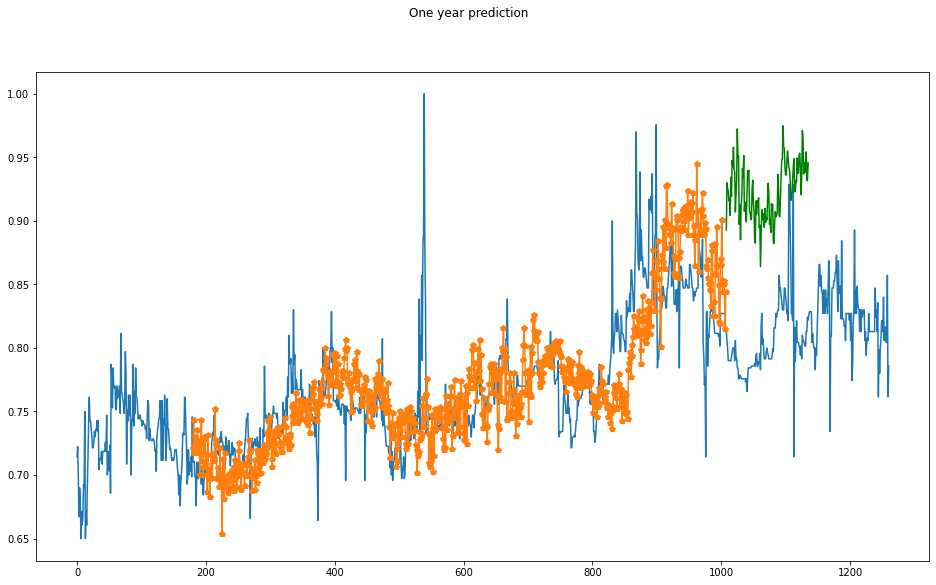

In [47]:
fig = plt.figure(figsize=(16,9))
plt.suptitle('One year prediction')
plt.plot(range(len(_APPLE_LOCAL)), _APPLE_LOCAL)
plt.plot(range(WINDOW_SIZE, len(_APPLE_TRAIN)), results_1y[:len(_APPLE_TRAIN) - WINDOW_SIZE], 'p-')
plt.plot(range(len(_APPLE_TRAIN), len(_APPLE_TRAIN) + 128), results_1y[-128:], 'g')
plt.show()

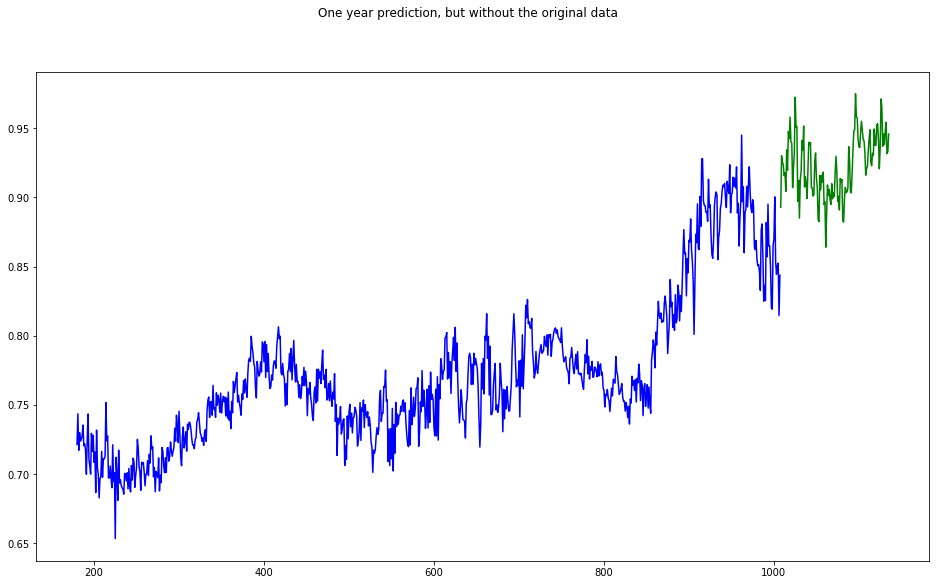

In [48]:
fig = plt.figure(figsize=(16,9))
plt.suptitle('One year prediction, but without the original data')
plt.plot(range(WINDOW_SIZE, len(_APPLE_TRAIN)), results_1y[:len(_APPLE_TRAIN) - WINDOW_SIZE], 'b')
plt.plot(range(len(_APPLE_TRAIN), len(_APPLE_TRAIN) + 128), results_1y[-128:], 'g')
plt.show()

In [49]:
time_series_pred.save_weights('./weights/forecast-normalised/forecast-normalised')
time_series_pred.save('./model/forecast-normalised')
time_series_pred.save('./model/forecast-normalised.h5')

INFO:tensorflow:Assets written to: ./model/forecast-normalised\assets


In [153]:
time_series_pred.predict(_APPLE_TRAIN[0:WINDOW_SIZE][np.newaxis])

array([[0.75868666]], dtype=float32)

In [36]:
for i in _input:
    print(i[0][0])
    print(i[1][0])
    break

tf.Tensor(
[0.73857143 0.74428571 0.74607143 0.75857143 0.74285714 0.71142857
 0.75857143 0.71142857 0.74428571 0.73952381 0.76285714 0.73452381
 0.71142857 0.72428571 0.76       0.73714286 0.73607143 0.72714286
 0.72       0.72142857 0.71761905 0.71142857 0.71349206 0.71265873
 0.71142857 0.71428571 0.72       0.72       0.72       0.71333333
 0.70440476 0.7        0.68428571 0.7        0.67571429 0.69285714
 0.7        0.70809524 0.73142857 0.73309524 0.73142857 0.76142857
 0.75714286 0.73714286 0.72178571 0.69285714 0.7        0.72
 0.7        0.71       0.70285714 0.71428571 0.69857143 0.74571429
 0.71142857 0.71       0.71071429 0.69880952 0.69880952 0.67571429
 0.71       0.71       0.69714286 0.71       0.70285714 0.70178571
 0.70142857 0.69285714 0.70571429 0.69285714 0.68428571 0.6952381
 0.69916667 0.70857143 0.70857143 0.69857143 0.69857143 0.71142857
 0.70333333 0.70333333 0.7        0.69857143 0.69857143 0.72571429
 0.72857143 0.73380952 0.73130952 0.74714286 0.71571429 0.

In [37]:
for i in _input:
    print(i[0][1])
    print(i[1][1])
    break

tf.Tensor(
[0.70571429 0.70714286 0.70761905 0.70869048 0.71       0.71
 0.73571429 0.70857143 0.69714286 0.70666667 0.70380952 0.71428571
 0.69714286 0.7        0.71714286 0.72142857 0.72       0.72107143
 0.72142857 0.72142857 0.72428571 0.74142857 0.72714286 0.7347619
 0.73404762 0.73571429 0.73857143 0.72857143 0.73428571 0.74857143
 0.73857143 0.74642857 0.73285714 0.76571429 0.74571429 0.83857143
 0.73285714 0.80952381 0.79738095 0.85714286 0.79       0.88238095
 0.89079365 1.         0.87455026 0.83578042 0.73285714 0.73571429
 0.73571429 0.73857143 0.74857143 0.74380952 0.7452381  0.74428571
 0.74428571 0.74428571 0.74428571 0.74428571 0.74428571 0.74428571
 0.74428571 0.74428571 0.73571429 0.74428571 0.73571429 0.73857143
 0.73857143 0.73571429 0.74428571 0.74428571 0.73571429 0.74428571
 0.73857143 0.73785714 0.73571429 0.73285714 0.77142857 0.74714286
 0.75714286 0.75047619 0.74833333 0.74714286 0.73857143 0.74714286
 0.74714286 0.75285714 0.74428571 0.74428571 0.73285714 0.